# setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
os.chdir('/content/drive/MyDrive/Coding/Python/input-sensitivity/')

In [6]:
%%capture
!pip install dm-haiku

In [7]:
# use TPUs
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

# use float32 matmul on TPU
import jax
jax.config.update('jax_default_matmul_precision', 'highest')

# check the number of GPU / TPU devices
n_dev = jax.local_device_count() 
print('num. devices:', n_dev)

num. devices: 8


# imports

In [8]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

# relative imports
from core import models, distributions, datasets, utils
from core.spmd import spmd
from core.sgd import train_sgd
from core.hmc import hmc_sampler

In [9]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

In [40]:
# load MNIST
x_train, y_train, x_test, y_test = datasets.mnist()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [41]:
# shrink dataset
def shrink(x, y, n_repeat):
    labels = jnp.argmax(y, 1)
    y = jnp.concatenate([y[labels==i][:n_repeat] for i in range(10)])
    x = jnp.concatenate([x[labels==i][:n_repeat] for i in range(10)])
    return x, y
x_train, y_train = shrink(x_train, y_train, 10)
x_test, y_test = shrink(x_test, y_test, 10)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(100, 784) (100, 10) (100, 784) (100, 10)


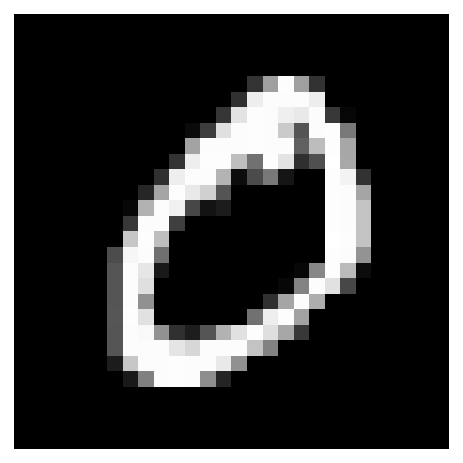

4.5 4.5


In [44]:
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()
print(jnp.argmax(y_train, 1).mean(), jnp.argmax(y_test, 1).mean())

# model

In [46]:
# define model
# batch_size = 1
T = 10**4
key = jax.random.PRNGKey(0)
prior_sd = 0.5
init_sd = 0.1
predict_fn, params_init = models.make_nn(key, x_train[:1])
n_params = len(params_init)
params_init = init_sd*jax.random.normal(key, [n_params])
log_likelihood_fn = distributions.make_xent_log_likelihood(predict_fn)
gauss_log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
sensi_log_prior_fn = distributions.make_input_sensitivity_fn(predict_fn, T)
gauss_log_posterior_fn = distributions.make_log_posterior_fn(log_likelihood_fn, gauss_log_prior_fn, len(x_train))
sensi_log_posterior_fn = distributions.make_log_posterior_fn(log_likelihood_fn, sensi_log_prior_fn, len(x_train))
# gauss_log_prob_val_and_grad_fn = spmd.make_epoch_log_prob_val_and_grad_fn(gauss_log_posterior_fn, x_train, y_train, n_dev, batch_size)
# sensi_log_prob_val_and_grad_fn = spmd.make_epoch_log_prob_val_and_grad_fn(sensi_log_posterior_fn, x_train, y_train, n_dev, batch_size)

In [47]:
%%time
# test model
print('num. params: ', n_params)
print('likelihood: ', log_likelihood_fn(params_init, x_train[:1], y_train[:1]))
print('gauss prior: ', gauss_log_prior_fn(params_init, x_train[:1])/len(x_train))
print('sens. prior: ', sensi_log_prior_fn(params_init, x_train[:1])/len(x_train))
# print('gauss post.: ', gauss_log_prob_val_and_grad_fn(params_init)[0])
# print('sens. post.: ', sensi_log_prob_val_and_grad_fn(params_init)[0])

num. params:  4085
likelihood:  -2.3358202
gauss prior:  -10.02135
sens. prior:  -0.08185494
CPU times: user 2.57 s, sys: 5.5 s, total: 8.08 s
Wall time: 12.7 s


In [48]:
def predict_chain(x, chain):
    def f(params):
        return predict_fn(x, params)
    return jax.vmap(f)(chain).mean(0)


def accuracy_params(params, x, y):
    y_hat = predict_fn(x, params)
    return (jnp.argmax(y_hat, axis=1) == jnp.argmax(y, axis=1)).mean()


def accuracy_chain(chain, x, y):
    y_hat = predict_chain(x, chain)
    return (jnp.argmax(y_hat, axis=1) == jnp.argmax(y, axis=1)).mean()

# SGD

## likelihood

0.96
0.45


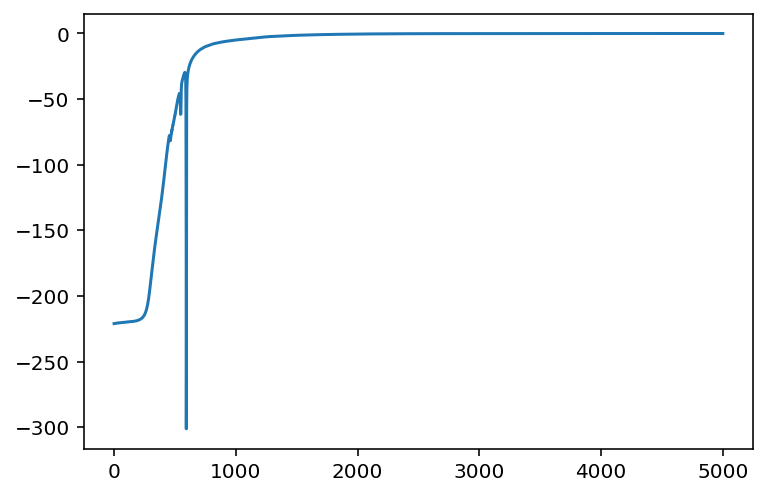

CPU times: user 2.06 s, sys: 811 ms, total: 2.87 s
Wall time: 3.27 s


In [101]:
%%time
batch_size = 12
n_epochs = 5_000
lr = 1e-3
log_prob_fn = log_likelihood_fn
params_sgd, val_history = train_sgd(key, log_prob_fn, params_init, x_train, y_train, n_epochs, n_dev, batch_size, lr)

print(accuracy_params(params_sgd, x_train, y_train))
print(accuracy_params(params_sgd, x_test, y_test))
plt.plot(val_history)
plt.show()

## Gaussian posterior

0.96999997
0.53999996


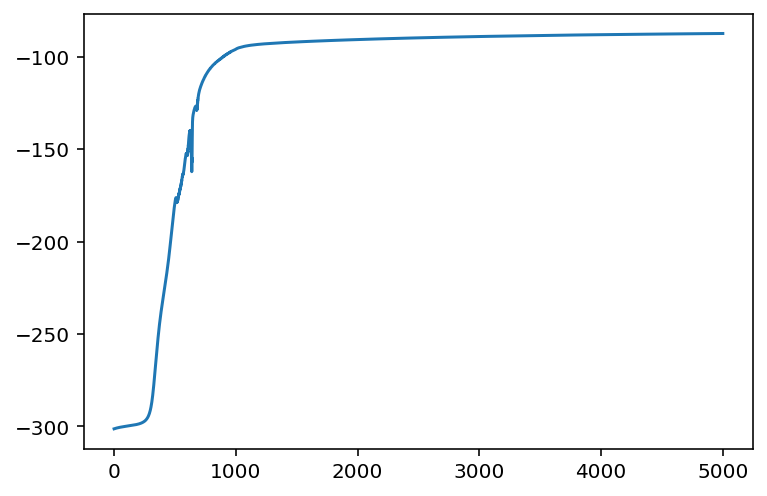

CPU times: user 2.14 s, sys: 828 ms, total: 2.96 s
Wall time: 3.37 s


In [50]:
%%time
batch_size = 12
n_epochs = 5_000
lr = 1e-3
log_prob_fn = gauss_log_posterior_fn
params_sgd, val_history = train_sgd(key, log_prob_fn, params_init, x_train, y_train, n_epochs, n_dev, batch_size, lr)

print(accuracy_params(params_sgd, x_train, y_train))
print(accuracy_params(params_sgd, x_test, y_test))
plt.plot(val_history)
plt.show()

## sensitivity posterior

1.0
0.69


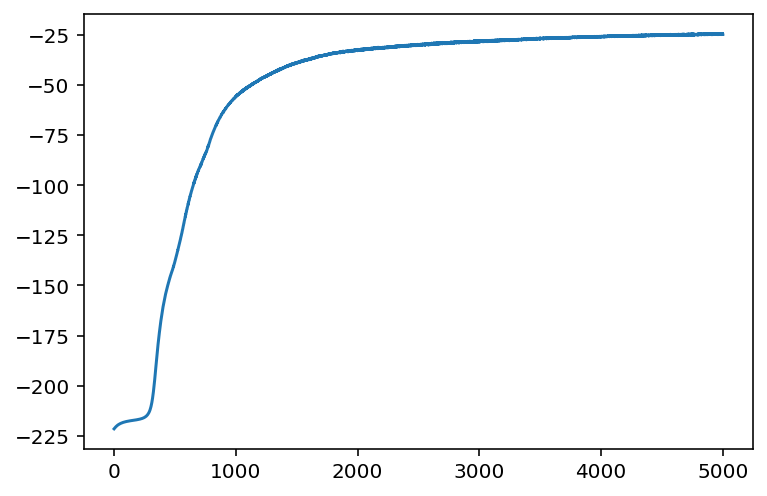

CPU times: user 1min 14s, sys: 4min 2s, total: 5min 16s
Wall time: 9min 14s


In [ ]:
%%time
batch_size = 12
n_epochs = 5_000
lr = 1e-3
log_prob_fn = sensi_log_posterior_fn
params_sgd, val_history = train_sgd(key, log_prob_fn, params_init, x_train, y_train, n_epochs, n_dev, batch_size, lr)

print(accuracy_params(params_sgd, x_train, y_train))
print(accuracy_params(params_sgd, x_test, y_test))
plt.plot(val_history)
plt.show()

# HMC

# likelihood

In [59]:
%%time
n_samples = 100
hmc_step_size = 5e-4
n_leapfrog_steps = 10_000
batch_size = 12
log_prob_fn = gauss_log_posterior_fn
key = jax.random.PRNGKey(0)
chain_hmc, avg_accept_prob = spmd(hmc_sampler, x_train, y_train, params_sgd, log_prob_fn, n_dev, batch_size, key, n_samples, n_leapfrog_steps, hmc_step_size)
print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

Avg. accept. prob.: 84.99%
CPU times: user 1min, sys: 2min 42s, total: 3min 42s
Wall time: 6min 49s


In [60]:
print(accuracy_chain(chain_hmc[-1:], x_train, y_train))
print(accuracy_chain(chain_hmc[-1:], x_test, y_test))

0.95
0.45


# adverserial attack

In [102]:
# set input image, target label
img_idx = 0
target_label = 3
target_label_one_hot = target_label == jnp.arange(10)
x = x_test[img_idx]
print('true label: ', jnp.argmax(y_test[img_idx]), 'target label: ', target_label)

# set model params
params = params_sgd

# compute adverserial noise
def target_likelihood(x):
    return log_likelihood_fn(params, x[None], target_label_one_hot)
adv_noise = jax.jacfwd(target_likelihood)(x)

true label:  0 target label:  3


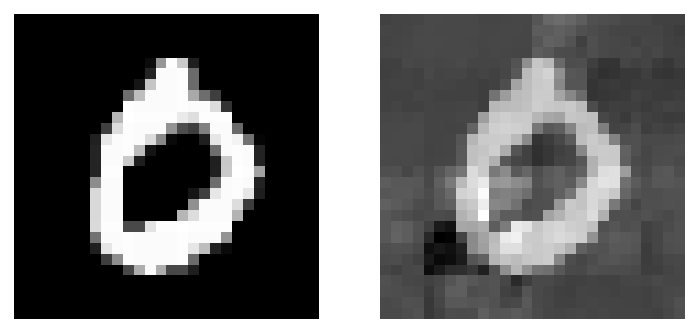

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [103]:
# make adverserial image
eps = 0.2
x_adv = x - eps*adv_noise

# plot original vs. adverserial
eps = 0.01
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x.reshape(28, 28), cmap='gray')
axs[1].imshow(x_adv.reshape(28, 28), cmap='gray')
axs[0].axis('off')
axs[1].axis('off')
plt.show()

# classify both images
print(jnp.round(jax.nn.softmax(predict_fn(x[None], params)[0]), 2))
print(jnp.round(jax.nn.softmax(predict_fn(x_adv[None], params)[0]), 2))